#CNN

In [ ]:
#Audio Processing Libraries
import librosa
from scipy import signal
#For Playing Audio
import IPython.display as ipd
#Array Processing
import numpy as np
#Data Visualization
import matplotlib.pyplot as plt

In [ ]:
path='FAULT.mp3'
emergency,sample_rate    = librosa.load(path, sr = 16000)
path='NO_FAULT.mp3'
non_emergency,sample_rate= librosa.load(path, sr =16000)

In [ ]:
from IPython.display import Audio
wn = Audio('FAULT.mp3', autoplay=True)
display(wn)

In [ ]:
from IPython.display import Audio
wn = Audio('NO_FAULT.mp3', autoplay=True)
display(wn)

In [ ]:
duration1 = librosa.get_duration(y=emergency,sr=16000)
duration2 = librosa.get_duration(y=non_emergency,sr=16000)
print("Duration of an emergency and Non Emergency (in min):",duration1/60,duration2/60)

Duration of an emergency and Non Emergency (in min): 1.389575 2.0695239583333334


In [ ]:
def prepare_data(samples, num_of_samples=32000, num_of_common=16000):
    data=[]
    for offset in range(0, len(samples), num_of_common):
        start = offset
        end   = offset + num_of_samples
        chunk = samples[start:end]
        if(len(chunk)==32000):
            data.append(chunk)
    return data

In [ ]:
emergency = prepare_data(emergency)
non_emergency = prepare_data(non_emergency)

In [ ]:
print("No. of Chunks of Emergency and Non Emergency:",len(emergency),len(non_emergency))

No. of Chunks of Emergency and Non Emergency: 82 123


<Figure size 1400x400 with 0 Axes>

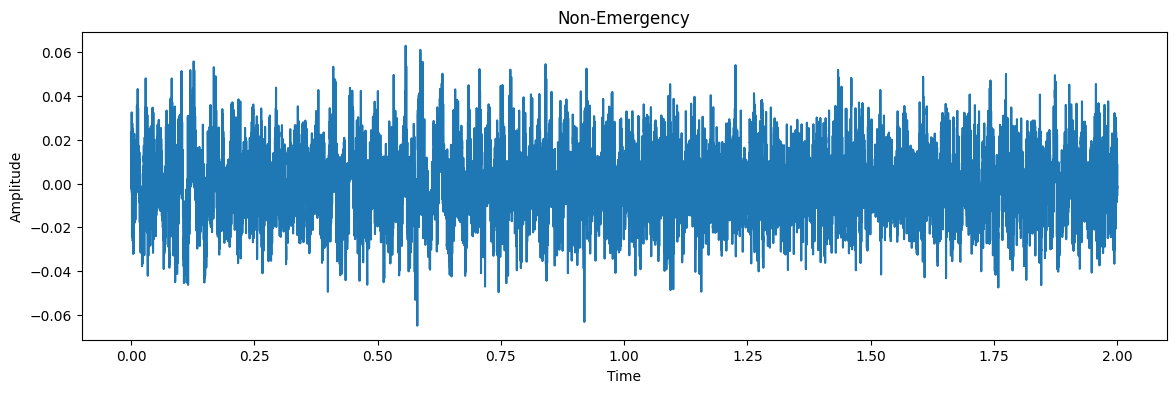

In [ ]:
plt.figure(figsize=(14, 4))
if len(emergency) > 103:
    plt.plot(np.linspace(0, 2, num=32000), emergency[103])
    plt.title('Emergency')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

plt.figure(figsize=(14, 4))
if len(non_emergency) > 102:
    plt.plot(np.linspace(0, 2, num=32000), non_emergency[102])
    plt.title('Non-Emergency')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')


In [ ]:
audio = np.concatenate([emergency,non_emergency])
labels1 = np.zeros(len(emergency))
labels2 = np.ones(len(non_emergency))
labels = np.concatenate([labels1,labels2])
print(audio.shape)

(205, 32000)


In [ ]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(audio),np.array(labels),
                                             stratify=labels,test_size = 0.1,
                                                   random_state=777,shuffle=True)

In [ ]:
x_tr_features  = x_tr.reshape(len(x_tr),-1,1)
x_val_features = x_val.reshape(len(x_val),-1,1)
print("Reshaped Array Size",x_tr_features.shape)

Reshaped Array Size (184, 32000, 1)


In [ ]:
from keras.layers import *
from keras.models import *
from keras.callbacks import *
from keras import backend as K
def cnn(x_tr):
  K.clear_session()
  inputs = Input(shape=(x_tr.shape[1],x_tr.shape[2]))
  #First Conv1D layer
  conv = Conv1D(8, 13, padding='same', activation='relu')(inputs)
  conv = Dropout(0.3)(conv)
  conv = MaxPooling1D(2)(conv)
  #Second Conv1D layer
  conv = Conv1D(16, 11, padding='same', activation='relu')(conv)
  conv = Dropout(0.3)(conv)
  conv = MaxPooling1D(2)(conv)
  #MaxPooling 1D
  conv = GlobalMaxPool1D()(conv)
  #Dense Layer
  conv = Dense(16, activation='relu')(conv)
  outputs = Dense(1,activation='sigmoid')(conv)
  model = Model(inputs, outputs)
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
  model_checkpoint = ModelCheckpoint('best_model.hdf5', monitor='val_acc',verbose=1, save_best_only=True, mode='max')
  return model, model_checkpoint
model, model_checkpoint = cnn(x_tr_features)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32000, 1)]        0         
                                                                 
 conv1d (Conv1D)             (None, 32000, 8)          112       
                                                                 
 dropout (Dropout)           (None, 32000, 8)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 16000, 8)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 16000, 16)         1424      
                                                                 
 dropout_1 (Dropout)         (None, 16000, 16)         0         
                                                             

In [ ]:
history=model.fit(x_tr_features, y_tr ,epochs=10,       callbacks=[model_checkpoint],
batch_size=32, validation_data=(x_val_features,y_val))

Epoch 1/10
6/6 [==============================] - ETA: 0s - loss: 0.6525 - acc: 0.5978
Epoch 1: val_acc improved from -inf to 0.61905, saving model to best_model.hdf5
6/6 [==============================] - 7s 987ms/step - loss: 0.6525 - acc: 0.5978 - val_loss: 0.6625 - val_acc: 0.6190
Epoch 2/10
6/6 [==============================] - ETA: 0s - loss: 0.6332 - acc: 0.5978
Epoch 2: val_acc did not improve from 0.61905
6/6 [==============================] - 7s 1s/step - loss: 0.6332 - acc: 0.5978 - val_loss: 0.6448 - val_acc: 0.6190
Epoch 3/10
6/6 [==============================] - ETA: 0s - loss: 0.6242 - acc: 0.5978
Epoch 3: val_acc did not improve from 0.61905
6/6 [==============================] - 7s 1s/step - loss: 0.6242 - acc: 0.5978 - val_loss: 0.6225 - val_acc: 0.6190
Epoch 4/10
6/6 [==============================] - ETA: 0s - loss: 0.6079 - acc: 0.5978
Epoch 4: val_acc did not improve from 0.61905
6/6 [==============================] - 7s 1s/step - loss: 0.6079 - acc: 0.5978 - va

In [ ]:
model.load_weights('best_model.hdf5')

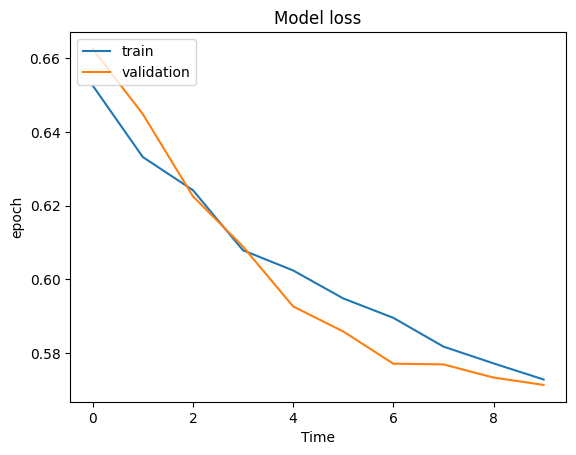

In [ ]:
plt.plot(history.history['loss'])

plt.plot(history.history['val_loss'])

plt.title('Model loss')

plt.xlabel('Time')

plt.ylabel('epoch')

plt.legend(['train','validation'],loc = 'upper left')

plt.show()

In [ ]:
_, acc = model.evaluate(x_val_features,y_val)
print("Validation Accuracy:",acc)

1/1 [==============================] - 0s 167ms/step - loss: 0.5714 - acc: 1.0000
Validation Accuracy: 1.0


In [ ]:
# !pip install gtts
!pip install pydub

In [ ]:
ind = 3
test_audio = x_val[ind]

ipd.Audio(test_audio, rate=16000)

In [ ]:
import IPython.display as ipd
from IPython.display import Audio
from gtts import gTTS

feature = x_val_features[ind]
prob = model.predict(feature.reshape(1, -1, 1))
if prob[0][0] < 0.5:
    pred = 'Fault'
    tts = gTTS(pred)
    tts.save('1.wav')
    sound_file = '1.wav'
    Audio(sound_file, autoplay=True)
else:
    pred = 'No Fault'
    tts = gTTS(pred)
    tts.save('1.wav')
    sound_file = '1.wav'
    Audio(sound_file, autoplay=True)

print("Prediction:", pred)

# Play the test_audio
# ipd.Audio(test_audio, rate=16000)

# Play the generated sound_file
ipd.Audio(sound_file, rate=16000)


1/1 [==============================] - 0s 48ms/step
Prediction: Fault


In [ ]:
ind = 20
test_audio = x_val[ind]

ipd.Audio(test_audio, rate=16000)

In [ ]:
import IPython.display as ipd
from IPython.display import Audio
from gtts import gTTS

feature = x_val_features[ind]
prob = model.predict(feature.reshape(1, -1, 1))
if prob[0][0] < 0.5:
    pred = 'Fault'
    tts = gTTS(pred)
    tts.save('1.wav')
    sound_file = '1.wav'
    Audio(sound_file, autoplay=True)
else:
    pred = 'No Fault'
    tts = gTTS(pred)
    tts.save('1.wav')
    sound_file = '1.wav'
    Audio(sound_file, autoplay=True)

print("Prediction:", pred)

# Play the test_audio
# ipd.Audio(test_audio, rate=16000)

# Play the generated sound_file
ipd.Audio(sound_file, rate=16000)


1/1 [==============================] - 0s 44ms/step
Prediction: No Fault
